## Tugas Besar II IF3270 Pembelajaran Mesin - LSTM

### Anggota Kelompok:
1. Suthasoma Mahardhika Munthe (13522098)
2. Marvin Scifo Y. Hutahaean (13522110)
3. Berto Richardo Togatorop (13522118)

In [52]:
import numpy as np
import pandas as pd
from customnn import LSTM, Embedded, FullyConnected, Dropout
from keras import layers
from keras import models
from sklearn.metrics import accuracy_score

url_train = "https://raw.githubusercontent.com/IndoNLP/nusax/main/datasets/sentiment/indonesian/train.csv"
url_valid = "https://raw.githubusercontent.com/IndoNLP/nusax/main/datasets/sentiment/indonesian/valid.csv"
url_test = "https://raw.githubusercontent.com/IndoNLP/nusax/main/datasets/sentiment/indonesian/test.csv"

df_train = pd.read_csv(url_train)
df_valid = pd.read_csv(url_valid)
df_test = pd.read_csv(url_test)

In [53]:
max_tokens = 10000
output_sequence_length = 100

vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=output_sequence_length
)
vectorizer.adapt(df_train['text'])
vectorizer_data = vectorizer(df_train['text'])
vectorizer_test = vectorizer(df_test['text'])
vectorizer_val = vectorizer(df_valid['text'])
vocabs = len(vectorizer.get_vocabulary())

y_train = df_train['label'].to_numpy()
y_test = df_test['label'].to_numpy()
y_valid = df_test['label'].to_numpy()

In [54]:
embedder = Embedded(vocabs, 100, embeddings_initializer='xavier')
embedded_vector = embedder.forward(vectorizer_data)

In [55]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_int = le.fit_transform(df_train['label'])
y_test_int = le.transform(df_test['label'])
y_valid_int = le.transform(df_valid['label'])

In [56]:
lstm_models = models.Sequential([
    layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
    layers.LSTM(units=128, return_sequences=False),
    layers.Dropout(0.2),
    layers.Dense(units=vocabs, activation='softmax')
])

lstm_models.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)
lstm_models.fit(
    vectorizer_data, y_train_int,
    epochs=10,
    batch_size=64,
    validation_split=0.2
)
test_loss, test_acc = lstm_models.evaluate(vectorizer_test, y_test_int)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.2199 - loss: 7.8877 - val_accuracy: 0.4400 - val_loss: 7.2159
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.3535 - loss: 6.7980 - val_accuracy: 0.4400 - val_loss: 5.3891
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.3151 - loss: 4.8864 - val_accuracy: 0.4400 - val_loss: 3.1216
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.2699 - loss: 2.7041 - val_accuracy: 0.4400 - val_loss: 1.5796
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.3291 - loss: 1.4728 - val_accuracy: 0.4400 - val_loss: 1.1801
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.3594 - loss: 1.1763 - val_accuracy: 0.4400 - val_loss: 1.0904
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.3349 - loss: 1.1361 - val_accuracy: 0.3600 - val_loss: 1.0802
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.4062 - loss: 1.0984 - val_accuracy: 0.3600 - val_loss: 1.075

In [57]:
embedding_weights = lstm_models.layers[0].get_weights()[0]
lstm_weights = lstm_models.layers[1].get_weights()
kernel, recurrent_kernel, bias_lstm = lstm_weights
dense_weights = lstm_models.layers[3].get_weights()
kernel_dense, bias_dense = dense_weights

In [59]:
from sklearn.metrics import f1_score

class LSTMFromScratch:
    def __init__(self, vocabs: int):
        self.embedding = Embedded(vocabs, 100, embeddings_initializer='uniform')
        self.lstm1 = LSTM(unit=128, input_size=100, timestep=100, return_sequence=False)
        self.drop = Dropout(dropout_rate=0.2)
        self.drop.training_status = False
        self.fc1 = FullyConnected(input_size=256, output_size=vocabs, activation='softmax', weight_init='xavier',
                                  lower=-0.05, upper=0.05, mean=0, variance=1, seed=None, use_rmsnorm=False)

    def forward(self, x):
        return self.fc1.forward(self.drop.forward(self.lstm1.forward(self.embedding.forward(x))))
    
lstm_from_scratch = LSTMFromScratch(vocabs=vocabs)

lstm_from_scratch.embedding.weight = embedding_weights.copy()
lstm_from_scratch.lstm1.input_weights = kernel.copy()
lstm_from_scratch.lstm1.input_weights = np.split(lstm_from_scratch.lstm1.input_weights, 4, axis=1)
lstm_from_scratch.lstm1.hidden_weights = recurrent_kernel.copy()
lstm_from_scratch.lstm1.hidden_weights = np.split(lstm_from_scratch.lstm1.hidden_weights, 4, axis=1)
lstm_from_scratch.lstm1.bias = bias_lstm.copy()
lstm_from_scratch.lstm1.bias = np.split(lstm_from_scratch.lstm1.bias, 4)
lstm_from_scratch.fc1.weights = kernel_dense.copy()
lstm_from_scratch.fc1.biases = bias_dense.copy()

sample_input = vectorizer_data.numpy()

keras_output = lstm_models(sample_input, training=False).numpy()

outputs = []
for i in range(sample_input.shape[0]):
    x = sample_input[i]
    output = lstm_from_scratch.forward(x)
    outputs.append(output)

outputs = np.stack(outputs)

keras_labels = np.argmax(keras_output, axis=1)
scratch_labels = np.argmax(outputs, axis=1)

f1 = f1_score(keras_labels, scratch_labels, average='macro')
keras_accuracy = accuracy_score(np.argmax(keras_output, axis=1), keras_labels)
scratch_accuracy = accuracy_score(keras_labels, scratch_labels)

print("Keras Model Accuracy:", keras_accuracy)
print("From-Scratch Model Accuracy:", scratch_accuracy)
print("Difference:", np.abs(keras_output - outputs).mean())
print("F1:", f1)

Keras Model Accuracy: 1.0
From-Scratch Model Accuracy: 1.0
Difference: 1.3434822786972365e-09
F1: 1.0


In [60]:
bi_models = models.Sequential([
    layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
    layers.Bidirectional(layers.LSTM(units=128, return_sequences=False)),
    layers.Dropout(0.2),
    layers.Dense(units=vocabs, activation='softmax')
])
bi_models.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)
bi_models.fit(
    vectorizer_data, y_train_int,
    epochs=10,
    batch_size=64,
    validation_split=0.2
)
test_loss, test_acc = bi_models.evaluate(vectorizer_test, y_test_int)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.2168 - loss: 7.8902 - val_accuracy: 0.3600 - val_loss: 7.0368
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.3789 - loss: 6.2423 - val_accuracy: 0.4400 - val_loss: 3.5490
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.3416 - loss: 2.8719 - val_accuracy: 0.4400 - val_loss: 1.2295
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.4155 - loss: 1.1897 - val_accuracy: 0.4300 - val_loss: 1.0610
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.3925 - loss: 1.1006 - val_accuracy: 0.3600 - val_loss: 1.0666
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.4174 - loss: 1.0707 - val_accuracy: 0.4400 - val_loss: 1.0379
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.3393 - loss: 1.0879 - val_accuracy: 0.5000 - val_loss: 1.0601
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.3738 - loss: 1.0767 - val_accuracy: 0.3600 - val_loss:

In [61]:
bi_embedding_weights = bi_models.layers[0].get_weights()[0]
bi_lstm_weights = bi_models.layers[1].get_weights()
bi_kernel, bi_recurrent_kernel, bi_bias_lstm, bi_kernel_reverse, bi_recurrent_kernel_reverse, bi_bias_lstm_reverse = bi_lstm_weights
bi_dense_weights = bi_models.layers[3].get_weights()
bi_kernel_dense, bi_bias_dense = bi_dense_weights

In [62]:
class BiLSTMFromScratch:
    def __init__(self, vocabs: int):
        self.embedding = Embedded(vocabs, 100, embeddings_initializer='uniform')
        self.lstm1 = LSTM(unit=128, input_size=100, timestep=100, return_sequence=False, bidirectional=True)
        self.drop = Dropout(dropout_rate=0.2)
        self.drop.training_status = False
        self.fc1 = FullyConnected(input_size=512, output_size=vocabs, activation='softmax', weight_init='xavier',
                                  lower=-0.05, upper=0.05, mean=0, variance=1, seed=None, use_rmsnorm=False)

    def forward(self, x):
        return self.fc1.forward(self.drop.forward(self.lstm1.forward(self.embedding.forward(x))))
    
bi_lstm_from_scratch = BiLSTMFromScratch(vocabs=vocabs)

bi_lstm_from_scratch.embedding.weight = bi_embedding_weights.copy()

bi_lstm_from_scratch.lstm1.input_weights = bi_kernel.copy()
bi_lstm_from_scratch.lstm1.input_weights = np.split(bi_lstm_from_scratch.lstm1.input_weights, 4, axis=1)
bi_lstm_from_scratch.lstm1.hidden_weights = bi_recurrent_kernel.copy()
bi_lstm_from_scratch.lstm1.hidden_weights = np.split(bi_lstm_from_scratch.lstm1.hidden_weights, 4, axis=1)
bi_lstm_from_scratch.lstm1.bias = bi_bias_lstm.copy()
bi_lstm_from_scratch.lstm1.bias = np.split(bi_lstm_from_scratch.lstm1.bias, 4)
bi_lstm_from_scratch.lstm1.input_weights_reverse = bi_kernel_reverse.copy()
bi_lstm_from_scratch.lstm1.input_weights_reverse = np.split(bi_lstm_from_scratch.lstm1.input_weights_reverse, 4, axis=1)
bi_lstm_from_scratch.lstm1.hidden_weights_reverse = bi_recurrent_kernel_reverse.copy()
bi_lstm_from_scratch.lstm1.hidden_weights_reverse = np.split(bi_lstm_from_scratch.lstm1.hidden_weights_reverse, 4, axis=1)
bi_lstm_from_scratch.lstm1.bias_reverse = bi_bias_lstm_reverse.copy()
bi_lstm_from_scratch.lstm1.bias_reverse = np.split(bi_lstm_from_scratch.lstm1.bias_reverse, 4)

bi_lstm_from_scratch.fc1.weights = bi_kernel_dense.copy()
bi_lstm_from_scratch.fc1.biases = bi_bias_dense.copy()

bi_sample_input = vectorizer_data.numpy()

bi_keras_output = bi_models(bi_sample_input, training=False).numpy()

bi_outputs = []
for i in range(bi_sample_input.shape[0]):
    x = bi_sample_input[i]
    bi_output = bi_lstm_from_scratch.forward(x)
    bi_outputs.append(bi_output)

bi_outputs = np.stack(bi_outputs)

bi_keras_labels = np.argmax(bi_keras_output, axis=1)
bi_scratch_labels = np.argmax(bi_outputs, axis=1)

bi_f1 = f1_score(bi_keras_labels, bi_scratch_labels, average='macro')
keras_accuracy = accuracy_score(np.argmax(bi_keras_output, axis=1), bi_keras_labels)
scratch_accuracy = accuracy_score(bi_keras_labels, bi_scratch_labels)

print("Keras Model Accuracy:", keras_accuracy)
print("From-Scratch Model Accuracy:", scratch_accuracy)
print("Difference:", np.abs(bi_keras_output - bi_outputs).mean())
print("F1:",bi_f1)

Keras Model Accuracy: 1.0
From-Scratch Model Accuracy: 0.964
Difference: 9.468962328601842e-06
F1: 0.9639168644557059


In [39]:
# LSTM Models Hyperparameter Analysis
lstm_models = [
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.LSTM(units=64),
        layers.Dropout(0.2),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.LSTM(units=64, return_sequences=True),
        layers.LSTM(units=128),
        layers.Dropout(0.2),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.LSTM(units=64, return_sequences=True),
        layers.LSTM(units=128, return_sequences=True),
        layers.LSTM(units=256),
        layers.Dropout(0.2),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.LSTM(units=32),
        layers.Dropout(0.2),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.LSTM(units=64),
        layers.Dropout(0.2),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.LSTM(units=128),
        layers.Dropout(0.2),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.LSTM(units=64),
        layers.Dropout(0.2),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.Bidirectional(layers.LSTM(units=64)),
        layers.Dropout(0.2),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.Bidirectional(layers.LSTM(units=64, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(units=64)),
        layers.Dropout(0.2),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
]

In [34]:
name_layers = [
    "1 Layer",
    "2 Layers",
    "3 Layers",
    "32 Cells",
    "64 Cells",
    "128 Cells",
    "Unidirectional",
    "Bidirectional",
    "Bidirectional 2 Layers"
]

1 Layer
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.1174 - loss: 7.9160 - val_accuracy: 0.2000 - val_loss: 7.6617
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.3346 - loss: 7.4867 - val_accuracy: 0.3600 - val_loss: 6.7986
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.3371 - loss: 6.5727 - val_accuracy: 0.3600 - val_loss: 5.7240
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.3235 - loss: 5.4597 - val_accuracy: 0.3600 - val_loss: 4.4465
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.3431 - loss: 4.1755 - val_accuracy: 0.3600 - val_loss: 3.2105
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.3864 - loss: 2.9927 - val_accuracy: 0.3600 - val_loss: 2.2543
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.3435 - loss: 2.1321 - val_accuracy: 0.3600 - val_loss: 1.6658
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.3791 - loss: 1.6169 - val_accuracy: 0.4400 - val_loss

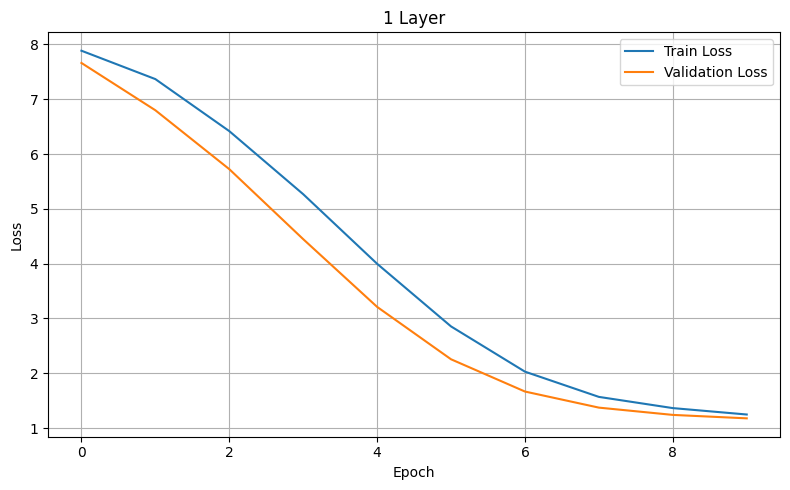


2 Layers
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 0.2184 - loss: 7.8374 - val_accuracy: 0.4400 - val_loss: 6.7942
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.3959 - loss: 6.4213 - val_accuracy: 0.4400 - val_loss: 4.8602
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.4183 - loss: 4.3590 - val_accuracy: 0.4400 - val_loss: 2.6696
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.3876 - loss: 2.3800 - val_accuracy: 0.4400 - val_loss: 1.4447
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.3933 - loss: 1.3994 - val_accuracy: 0.4400 - val_loss: 1.1529
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.4394 - loss: 1.1849 - val_accuracy: 0.3600 - val_loss: 1.0985
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.3691 - loss: 1.1176 - val_accuracy: 0.3600 - val_loss: 1.1021
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.3637 - loss: 1.1187 - val_accuracy: 0.3600 -

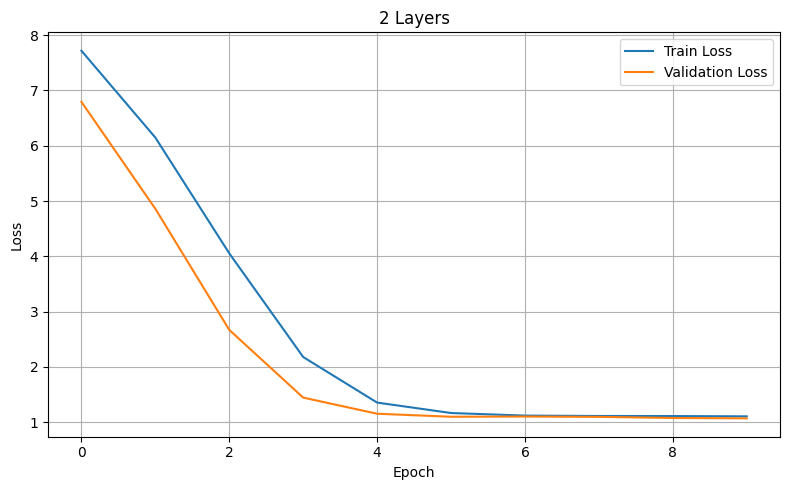


3 Layers
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 371ms/step - accuracy: 0.2481 - loss: 7.7184 - val_accuracy: 0.4400 - val_loss: 5.3382
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 328ms/step - accuracy: 0.3660 - loss: 4.4790 - val_accuracy: 0.4400 - val_loss: 1.7508
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 307ms/step - accuracy: 0.4018 - loss: 1.5143 - val_accuracy: 0.4400 - val_loss: 1.0929
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 306ms/step - accuracy: 0.3853 - loss: 1.1195 - val_accuracy: 0.3600 - val_loss: 1.0903
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 317ms/step - accuracy: 0.3730 - loss: 1.0990 - val_accuracy: 0.4400 - val_loss: 1.0561
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step - accuracy: 0.4102 - loss: 1.0732 - val_accuracy: 0.3600 - val_loss: 1.0598
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step - accuracy: 0.3730 - loss: 1.0969 - val_accuracy: 0.3600 - val_loss: 1.0850
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 315ms/step - accuracy: 0.3392 - loss: 1.1235 - val_accuracy: 0.4400 -

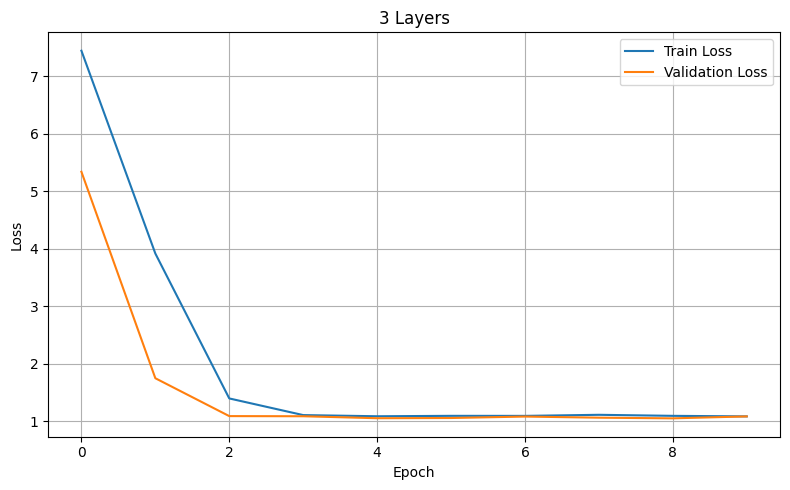


32 Cells
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.1176 - loss: 7.9277 - val_accuracy: 0.2000 - val_loss: 7.8167
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.2774 - loss: 7.7565 - val_accuracy: 0.2000 - val_loss: 7.4835
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.2544 - loss: 7.3778 - val_accuracy: 0.2000 - val_loss: 6.9997
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.2340 - loss: 6.8647 - val_accuracy: 0.2000 - val_loss: 6.4087
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2315 - loss: 6.2617 - val_accuracy: 0.2000 - val_loss: 5.7237
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2324 - loss: 5.5671 - val_accuracy: 0.2000 - val_loss: 5.0199
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.2594 - loss: 4.8479 - val_accuracy: 0.2000 - val_loss: 4.3610
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.2453 - loss: 4.2053 - val_accuracy: 0.2000 - val_lo

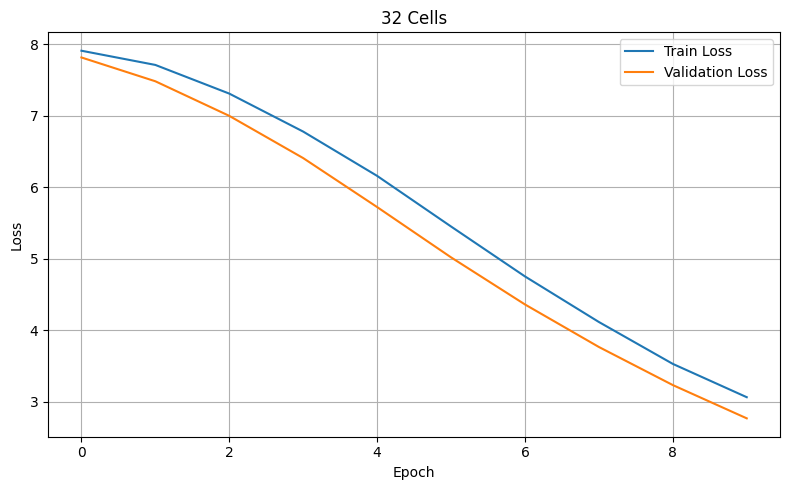


64 Cells
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.2232 - loss: 7.9189 - val_accuracy: 0.4400 - val_loss: 7.6661
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.3463 - loss: 7.5026 - val_accuracy: 0.4400 - val_loss: 6.7678
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.3583 - loss: 6.5634 - val_accuracy: 0.4400 - val_loss: 5.6735
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.3765 - loss: 5.4280 - val_accuracy: 0.4400 - val_loss: 4.3985
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.3868 - loss: 4.1557 - val_accuracy: 0.4400 - val_loss: 3.1878
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.3639 - loss: 3.0079 - val_accuracy: 0.4400 - val_loss: 2.2418
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.3691 - loss: 2.1385 - val_accuracy: 0.4400 - val_loss: 1.6520
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.3657 - loss: 1.6346 - val_accuracy: 0.4400 - val_lo

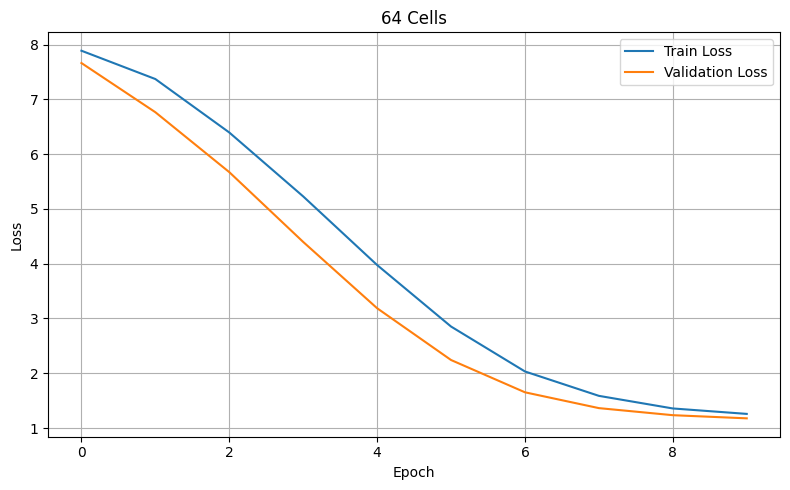


128 Cells
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.2493 - loss: 7.9056 - val_accuracy: 0.4400 - val_loss: 7.3326
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.3594 - loss: 6.9349 - val_accuracy: 0.4400 - val_loss: 5.5075
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.3565 - loss: 5.0515 - val_accuracy: 0.4400 - val_loss: 3.2959
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.3710 - loss: 2.8808 - val_accuracy: 0.4400 - val_loss: 1.6382
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.3722 - loss: 1.5356 - val_accuracy: 0.4400 - val_loss: 1.1895
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.3626 - loss: 1.2026 - val_accuracy: 0.4400 - val_loss: 1.1040
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.3634 - loss: 1.1305 - val_accuracy: 0.3600 - val_loss: 1.0849
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.3559 - loss: 1.1284 - val_accuracy: 0.3600 

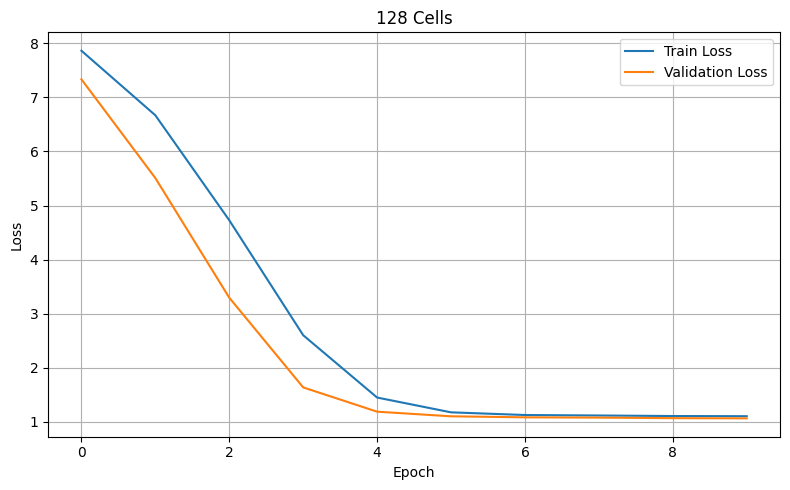


Unidirectional
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.2366 - loss: 7.9127 - val_accuracy: 0.3600 - val_loss: 7.6347
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.3745 - loss: 7.4499 - val_accuracy: 0.3600 - val_loss: 6.7787
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.3960 - loss: 6.5565 - val_accuracy: 0.3600 - val_loss: 5.7416
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.3693 - loss: 5.4520 - val_accuracy: 0.3600 - val_loss: 4.4636
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.3742 - loss: 4.1759 - val_accuracy: 0.3600 - val_loss: 3.2346
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.3787 - loss: 2.9839 - val_accuracy: 0.3600 - val_loss: 2.2854
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.3965 - loss: 2.1715 - val_accuracy: 0.3600 - val_loss: 1.6972
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.3740 - loss: 1.6732 - val_accuracy: 0.3600 - 

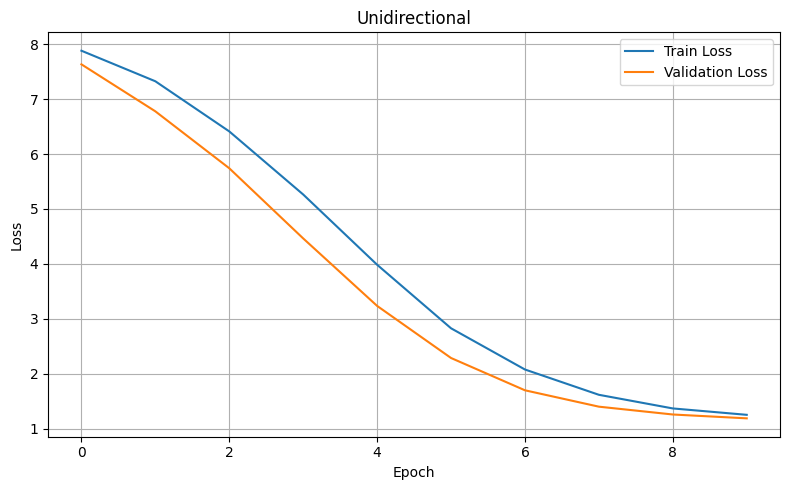


Bidirectional
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.1649 - loss: 7.9276 - val_accuracy: 0.3600 - val_loss: 7.7340
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.4305 - loss: 7.5567 - val_accuracy: 0.4400 - val_loss: 6.6744
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.4299 - loss: 6.2527 - val_accuracy: 0.4400 - val_loss: 4.7600
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.3363 - loss: 4.2650 - val_accuracy: 0.4400 - val_loss: 2.6615
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.3691 - loss: 2.2806 - val_accuracy: 0.4400 - val_loss: 1.3690
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.3858 - loss: 1.2946 - val_accuracy: 0.4400 - val_loss: 1.1093
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.3874 - loss: 1.1337 - val_accuracy: 0.5200 - val_loss: 1.0644
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.4021 - loss: 1.0941 - val_accuracy: 0.5

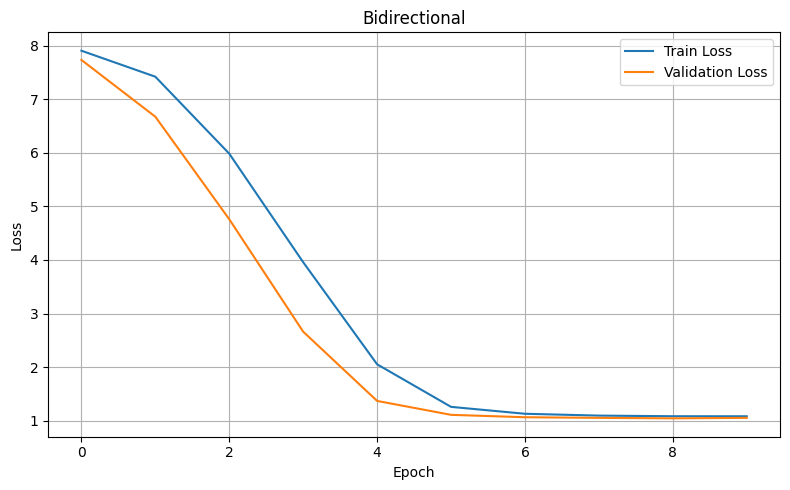


Bidirectional 2 Layers
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 298ms/step - accuracy: 0.2220 - loss: 7.9065 - val_accuracy: 0.4700 - val_loss: 7.4677
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.4296 - loss: 7.1818 - val_accuracy: 0.2000 - val_loss: 5.9685
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.2691 - loss: 5.5189 - val_accuracy: 0.2000 - val_loss: 3.9190
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - accuracy: 0.2342 - loss: 3.4341 - val_accuracy: 0.2000 - val_loss: 1.9351
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.2717 - loss: 1.7270 - val_accuracy: 0.3600 - val_loss: 1.2445
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.4002 - loss: 1.2194 - val_accuracy: 0.3600 - val_loss: 1.1085
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.3510 - loss: 1.1445 - val_accuracy: 0.4400 - val_loss: 1.0727
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.3904 - loss: 1.1118 - val_accu

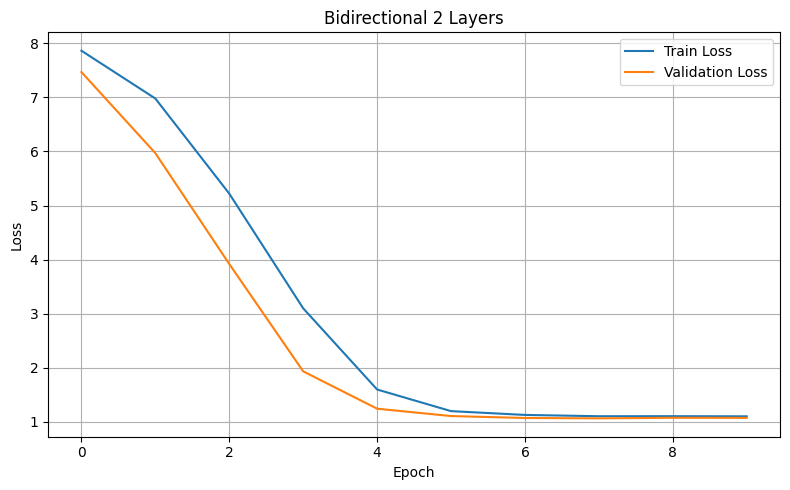

In [ ]:
import matplotlib.pyplot as plt

n = 0

for model in lstm_models:
    print(name_layers[n])
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=['accuracy']
    )
    history = model.fit(
        vectorizer_data, y_train_int,
        epochs=10,
        batch_size=64,
        validation_split=0.2
    )
    test_loss, test_acc = model.evaluate(vectorizer_val, y_valid_int)

    y_pred_probs = model.predict(vectorizer_val)
    y_pred = np.argmax(y_pred_probs, axis=1)
    f1 = f1_score(y_valid_int, y_pred, average='macro')

    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"F1 Score: {f1:.4f}")

    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(name_layers[n])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    n += 1
    print()



Bidirectional
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.3595 - loss: 1.0950 - val_accuracy: 0.4400 - val_loss: 1.0637
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3888 - loss: 1.0790 - val_accuracy: 0.3700 - val_loss: 1.0619
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3465 - loss: 1.0979 - val_accuracy: 0.3600 - val_loss: 1.0715
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4169 - loss: 1.0826 - val_accuracy: 0.6400 - val_loss: 1.0553
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.4464 - loss: 1.0657 - val_accuracy: 0.6100 - val_loss: 1.0381
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4701 - loss: 1.0675 - val_accuracy: 0.5500 - val_loss: 1.0461
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4964 - loss: 1.0432 - val_accuracy: 0.6100 - val_loss: 1.0317
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5450 - loss: 1.0420 - val_accuracy: 0.6200 - va

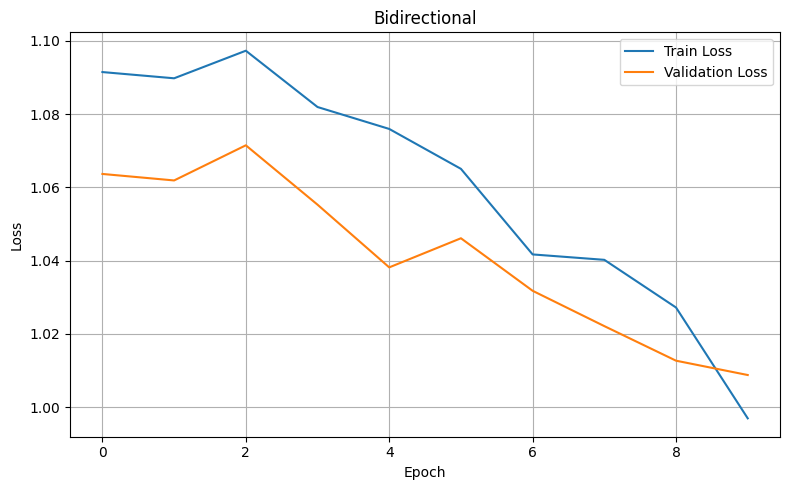

In [41]:
print(name_layers[7])
lstm_models[7].compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)
history = lstm_models[7].fit(
    vectorizer_data, y_train_int,
    epochs=10,
    batch_size=64,
    validation_split=0.2
)
test_loss, test_acc = lstm_models[7].evaluate(vectorizer_val, y_valid_int)

y_pred_probs = lstm_models[7].predict(vectorizer_val)
y_pred = np.argmax(y_pred_probs, axis=1)
f1 = f1_score(y_valid_int, y_pred, average='macro')

print(f"Test Accuracy: {test_acc:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(name_layers[7])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()